![tower_bridge](tower_bridge.jpg)

As the climate changes, predicting the weather becomes ever more important for businesses. You have been asked to support on a machine learning project with the aim of building a pipeline to predict the climate in London, England. Specifically, the model should predict mean temperature in degrees Celsius (°C).

Since the weather depends on a lot of different factors, you will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, you will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `mlflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - **target** mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [1]:
# Run this cell to install mlflow
!pip install mlflow

Defaulting to user installation because normal site-packages is not writeable


# Load data

* Reading the data
* Determining columns names, data types, number of non-null values

In [2]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Read in the data
weather = pd.read_csv("london_weather.csv")

# Start coding here
# Use as many cells as you like
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


# Data cleaning

* `date` column is the wrong data type
* We must convert it to `datetime`

In [3]:
weather["date"] = pd.to_datetime(weather["date"], format="%Y%m%d")
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              15341 non-null  datetime64[ns]
 1   cloud_cover       15322 non-null  float64       
 2   sunshine          15341 non-null  float64       
 3   global_radiation  15322 non-null  float64       
 4   max_temp          15335 non-null  float64       
 5   mean_temp         15305 non-null  float64       
 6   min_temp          15339 non-null  float64       
 7   precipitation     15335 non-null  float64       
 8   pressure          15337 non-null  float64       
 9   snow_depth        13900 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 1.2 MB


* Creating new columns

In [4]:
weather["year"] = weather.date.dt.year
weather["month"] = weather.date.dt.month
weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,year,month
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0,1979,1
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0,1979,1
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0,1979,1
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0,1979,1
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0,1979,1


# Exploratory data analysis

* Visualizing `mean_temp` versus `year`

<AxesSubplot: xlabel='year', ylabel='mean_temp'>

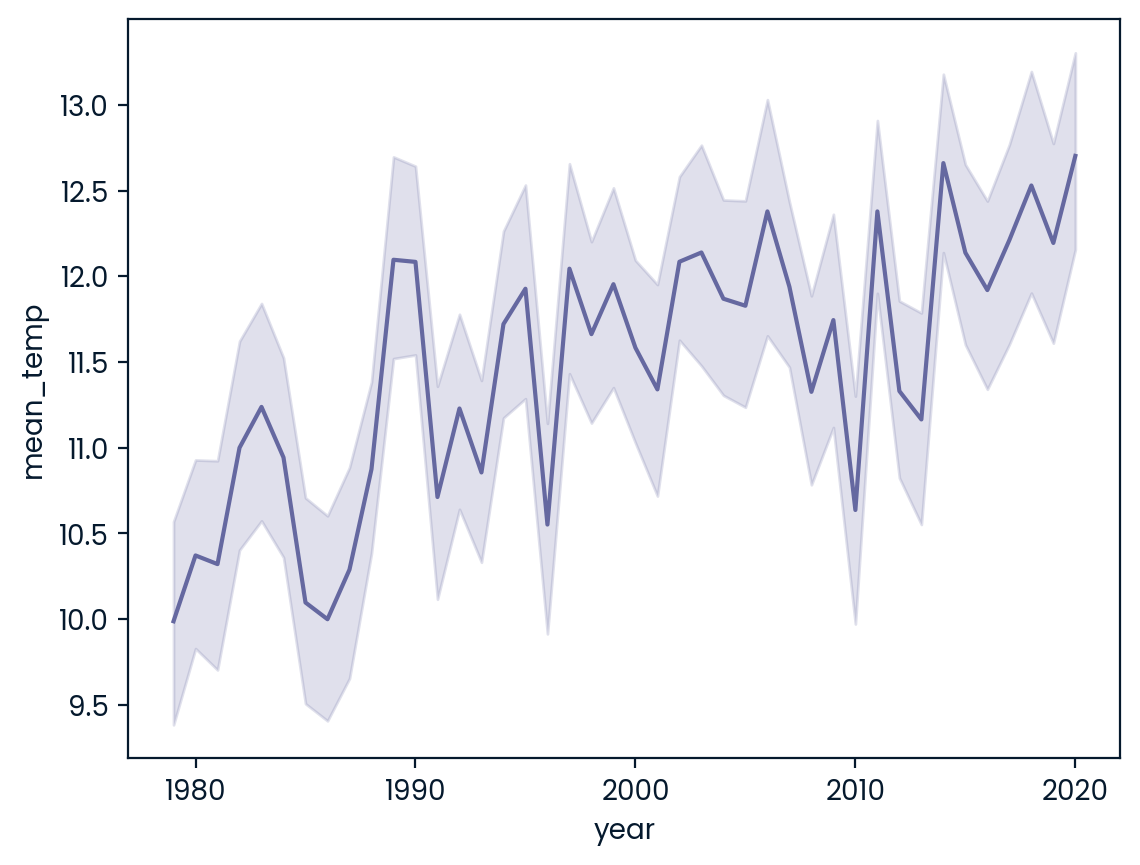

In [5]:
sns.lineplot(y=weather["mean_temp"], x=weather["year"], data=weather)

* Visualizing `mean_temp` in each `month`

<AxesSubplot: xlabel='month', ylabel='mean_temp'>

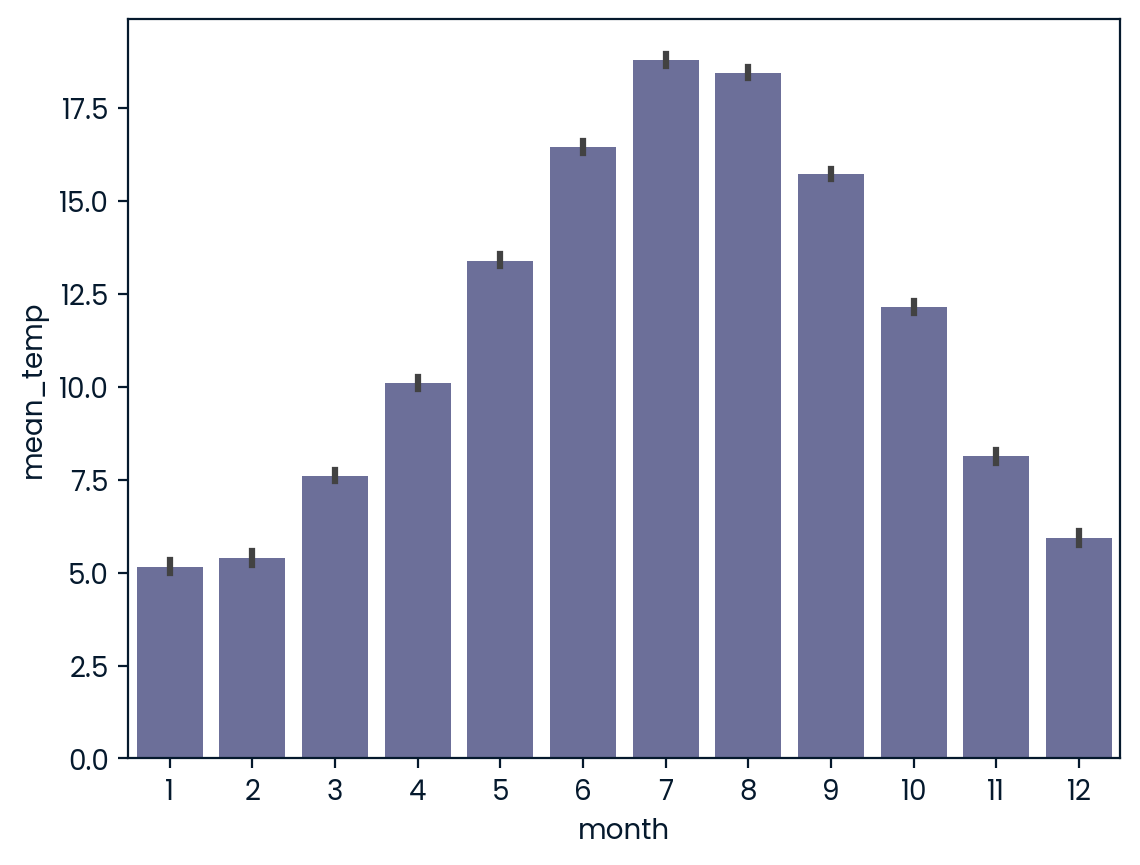

In [6]:
sns.barplot(y=weather["mean_temp"], x=weather["month"], data=weather)

* Visualizing correlation between variables

<AxesSubplot: >

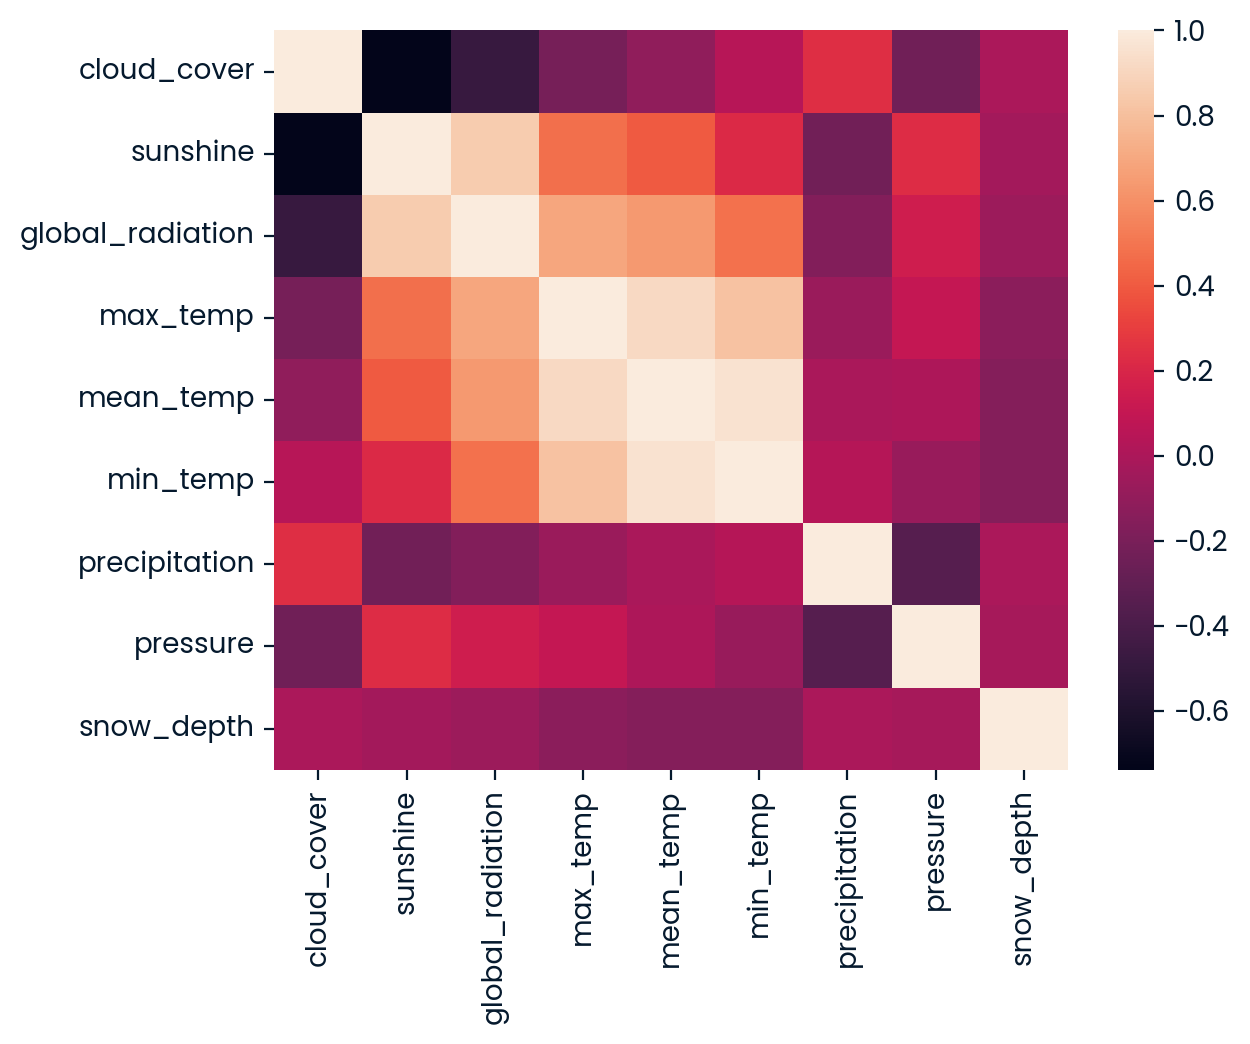

In [7]:
sns.heatmap(weather.drop(["date", "year", "month"], axis=1).corr())

# Feature selection

* Choose variables for predicting `mean_temp`

In [8]:
selected_features = weather[["max_temp", "min_temp", "mean_temp"]]
X = selected_features.drop(["mean_temp"], axis=1)
y = selected_features["mean_temp"].dropna()
X = X.loc[weather.dropna(subset=["mean_temp"]).index]

In [9]:
X.head()

,max_temp,min_temp
0,2.3,-7.5
1,1.6,-7.5
2,1.3,-7.2
3,-0.3,-6.5
4,5.6,-1.4


In [10]:
y.head()

0   -4.1
1   -2.6
2   -2.8
3   -2.6
4   -0.8
Name: mean_temp, dtype: float64

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15305 entries, 0 to 15340
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   max_temp  15305 non-null  float64
 1   min_temp  15305 non-null  float64
dtypes: float64(2)
memory usage: 358.7 KB


In [12]:
y.info()

<class 'pandas.core.series.Series'>
Int64Index: 15305 entries, 0 to 15340
Series name: mean_temp
Non-Null Count  Dtype  
--------------  -----  
15305 non-null  float64
dtypes: float64(1)
memory usage: 239.1 KB


# Preprocess data

* Splitting data into training and testing
* Impute values
* Normalize

In [13]:
# Split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute values
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_test)

# Normalizing data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_imputed)
X_test_norm = scaler.transform(X_test_imputed)

# ML training and evaluation

* Let's try different hyperparameters
* Log and evaluate the results

In [14]:
mlflow.create_experiment("Forest Model")
mlflow.set_experiment("Forest Model")
mlflow.set_experiment_tag("version", "1.0")

for idx, depth in enumerate([1, 5, 10, 20]):
    with mlflow.start_run(run_name=f"run_{idx}"):
        dt_regressor = DecisionTreeRegressor(max_depth=depth)
        dt_regressor.fit(X_train_norm, y_train)
        dt_pred = dt_regressor.predict(X_test_norm)
        dt_rmse = mean_squared_error(y_test, dt_pred, squared=False)
        
        mlflow.log_param("dt_model", "DecisionTree")
        mlflow.log_param("max_depth", depth)
        mlflow.log_metric("dt_rmse", dt_rmse)
        
        rf_regressor = RandomForestRegressor(max_depth=depth)
        rf_regressor.fit(X_train_norm, y_train)
        rf_pred = rf_regressor.predict(X_test_norm)
        rf_rmse = mean_squared_error(y_test, rf_pred, squared=False)
        
        mlflow.log_param("rf_model", "RandomForest")
        mlflow.log_param("max_depth", depth)
        mlflow.log_metric("rf_rmse", rf_rmse)

# Searching logged results

* Search all runs

In [15]:
experiment_results = mlflow.search_runs(search_all_experiments=True)
experiment_results

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.dt_rmse,metrics.rf_rmse,params.dt_model,params.rf_model,params.max_depth,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.source.name
0,62bc0db9930a4a83a5c13dca630f8ae5,457973149303370363,FINISHED,file:///work/files/workspace/mlruns/4579731493...,2024-05-10 01:17:10.016000+00:00,2024-05-10 01:17:12.309000+00:00,1.383707,1.149238,DecisionTree,RandomForest,20,repl,LOCAL,run_3,/usr/lib/python3/dist-packages/python_kernel/k...
1,a029e4c4c4a8490392e04eaebc13cab1,457973149303370363,FINISHED,file:///work/files/workspace/mlruns/4579731493...,2024-05-10 01:17:08.078000+00:00,2024-05-10 01:17:09.941000+00:00,1.108344,1.034584,DecisionTree,RandomForest,10,repl,LOCAL,run_2,/usr/lib/python3/dist-packages/python_kernel/k...
2,cf3e63493b164d60bdd231222bf753c5,457973149303370363,FINISHED,file:///work/files/workspace/mlruns/4579731493...,2024-05-10 01:17:06.489000+00:00,2024-05-10 01:17:07.998000+00:00,1.262605,1.110174,DecisionTree,RandomForest,5,repl,LOCAL,run_1,/usr/lib/python3/dist-packages/python_kernel/k...
3,77e869b8f94f4e37bddf69c5b16920ed,457973149303370363,FINISHED,file:///work/files/workspace/mlruns/4579731493...,2024-05-10 01:17:05.250000+00:00,2024-05-10 01:17:06.407000+00:00,3.407016,3.297176,DecisionTree,RandomForest,1,repl,LOCAL,run_0,/usr/lib/python3/dist-packages/python_kernel/k...
